# Hierarchical clustering: structured vs unstructured ward

In Hierarchical Clustering, we allow the machine to determined the most applicable unumber of clusters according to the provided data.

## hierarchical thinking

Hierarchical thinking is shown when you can take a structure with many elements, arrange those elements into a pattern, give that pattern a symbol, and then use that symbol as an element in another structure with many elements, repeating this process many times for many layers of "complexity."

One of the easiest examples of hierarchical thinking is written language. First you have lines, then you take those lines and put them together to make shapes, called letters. Next you arrange those letters into patterns and call them words with unique names and meanings for each word. Then we take these words to form patterns of meaning called sentences. Then we put those together to express entire ideas, concepts, and general knowledge.

With this, humans the only species on this planet capable of actually "compounding" their knowledge, building on top of pre-existing knowledge, continually adding layers of complexity, yet easily understanding it because we've employed hierarchical thinking.

Hierarchical clustering is a general family of clustering algorithms that build nested clusters by merging or splitting them successively. This hierarchy of clusters is represented as a tree (or dendrogram). The root of the tree is the unique cluster that gathers all the samples, the leaves being the clusters with only one sample.

The AgglomerativeClustering object performs a hierarchical clustering using a bottom up approach: each observation starts in its own cluster, and clusters are successively merged together. The linkage criteria determines the metric used for the merge strategy:

- Ward minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.
- Maximum or complete linkage minimizes the maximum distance between observations of pairs of clusters.
- Average linkage minimizes the average of the distances between all observations of pairs of clusters.

AgglomerativeClustering can also scale to large number of samples when it is used jointly with a connectivity matrix, but is computationally expensive when no connectivity constraints are added between samples: it considers at each step all the possible merges.

## FeatureAgglomeration

The FeatureAgglomeration uses agglomerative clustering to group together features that look very similar, thus decreasing the number of features. It is a dimensionality reduction tool, see Unsupervised dimensionality reduction.

### Different linkage type: Ward, complete and average linkage

AgglomerativeClustering supports Ward, average, and complete linkage strategies.

Agglomerative cluster has a “rich get richer” behavior that leads to uneven cluster sizes. In this regard, complete linkage is the worst strategy, and Ward gives the most regular sizes. However, the affinity (or distance used in clustering) cannot be varied with Ward, thus for non Euclidean metrics, average linkage is a good alternative.

Automatically created module for IPython interactive environment
Computing embedding
Done.
ward : 0.78s
average : 0.55s
complete : 0.47s


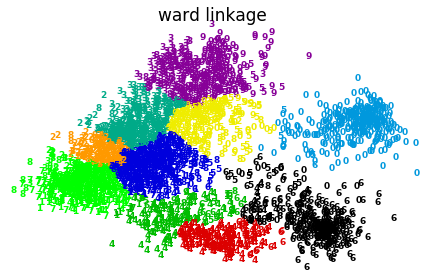

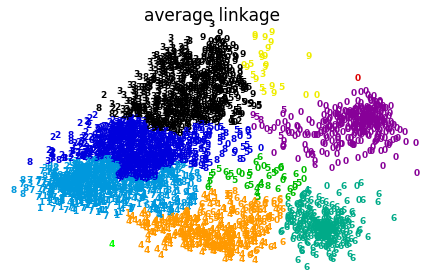

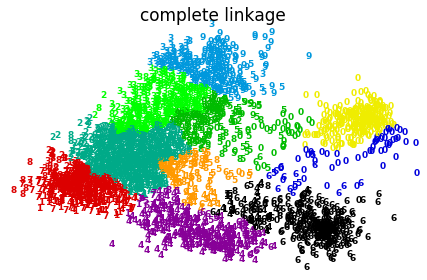

In [1]:
# Authors: Gael Varoquaux
# License: BSD 3 clause (C) INRIA 2014

print(__doc__)
from time import time

import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt

from sklearn import manifold, datasets

digits = datasets.load_digits(n_class=10)
X = digits.data
y = digits.target
n_samples, n_features = X.shape

np.random.seed(0)

def nudge_images(X, y):
    # Having a larger dataset shows more clearly the behavior of the
    # methods, but we multiply the size of the dataset only by 2, as the
    # cost of the hierarchical clustering methods are strongly
    # super-linear in n_samples
    shift = lambda x: ndimage.shift(x.reshape((8, 8)),
                                  .3 * np.random.normal(size=2),
                                  mode='constant',
                                  ).ravel()
    X = np.concatenate([X, np.apply_along_axis(shift, 1, X)])
    Y = np.concatenate([y, y], axis=0)
    return X, Y


X, y = nudge_images(X, y)


#----------------------------------------------------------------------
# Visualize the clustering
def plot_clustering(X_red, X, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(6, 4))
    for i in range(X_red.shape[0]):
        plt.text(X_red[i, 0], X_red[i, 1], str(y[i]),
                 color=plt.cm.spectral(labels[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout()

#----------------------------------------------------------------------
# 2D embedding of the digits dataset
print("Computing embedding")
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)
print("Done.")

from sklearn.cluster import AgglomerativeClustering

for linkage in ('ward', 'average', 'complete'):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=10)
    t0 = time()
    clustering.fit(X_red)
    print("%s : %.2fs" % (linkage, time() - t0))

    plot_clustering(X_red, X, clustering.labels_, "%s linkage" % linkage)


plt.show()

### Adding connectivity constraints¶

An interesting aspect of AgglomerativeClustering is that connectivity constraints can be added to this algorithm (only adjacent clusters can be merged together), through a connectivity matrix that defines for each sample the neighboring samples following a given structure of the data. For instance, in the swiss-roll example below, the connectivity constraints forbid the merging of points that are not adjacent on the swiss roll, and thus avoid forming clusters that extend across overlapping folds of the roll.

In a first step, the hierarchical clustering is performed without connectivity constraints on the structure and is solely based on distance, whereas in a second step the clustering is restricted to the k-Nearest Neighbors graph: it’s a hierarchical clustering with structure prior.

Some of the clusters learned without connectivity constraints do not respect the structure of the swiss roll and extend across different folds of the manifolds. On the opposite, when opposing connectivity constraints, the clusters form a nice parcellation of the swiss roll.

These constraint are useful to impose a certain local structure, but they also make the algorithm faster, especially when the number of the samples is high.

The connectivity constraints are imposed via an connectivity matrix: a scipy sparse matrix that has elements only at the intersection of a row and a column with indices of the dataset that should be connected. This matrix can be constructed from a-priori information: for instance, you may wish to cluster web pages by only merging pages with a link pointing from one to another. It can also be learned from the data, for instance using sklearn.neighbors.kneighbors_graph to restrict merging to nearest neighbors as in this example, or using sklearn.feature_extraction.image.grid_to_graph to enable only merging of neighboring pixels on an image, as in the raccoon face example.

Automatically created module for IPython interactive environment
Compute unstructured hierarchical clustering...
Elapsed time: 0.27s
Number of points: 1500
Compute structured hierarchical clustering...
Elapsed time: 0.32s
Number of points: 1500


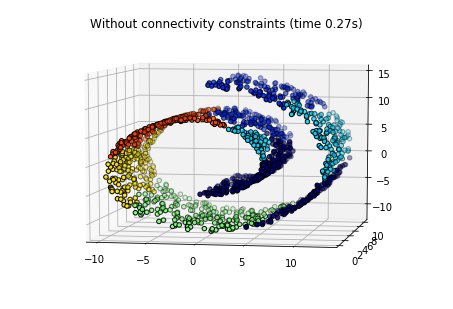

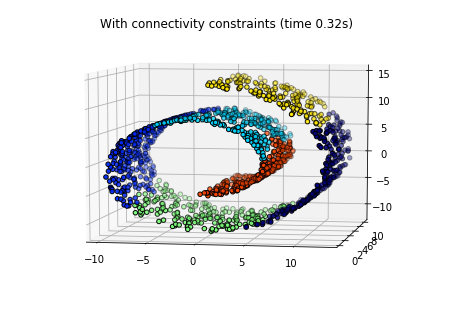

In [1]:
# Authors : Vincent Michel, 2010
#           Alexandre Gramfort, 2010
#           Gael Varoquaux, 2010
# License: BSD 3 clause

print(__doc__)

import time as time
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets.samples_generator import make_swiss_roll

# #############################################################################
# Generate data (swiss roll dataset)
n_samples = 1500
noise = 0.05
X, _ = make_swiss_roll(n_samples, noise)
# Make it thinner
X[:, 1] *= .5

# #############################################################################
# Compute clustering
print("Compute unstructured hierarchical clustering...")
st = time.time()
ward = AgglomerativeClustering(n_clusters=6, linkage='ward').fit(X)
elapsed_time = time.time() - st
label = ward.labels_
print("Elapsed time: %.2fs" % elapsed_time)
print("Number of points: %i" % label.size)

# #############################################################################
# Plot result
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
for l in np.unique(label):
    ax.scatter(X[label == l, 0], X[label == l, 1], X[label == l, 2],
               color=plt.cm.jet(np.float(l) / np.max(label + 1)),
               s=20, edgecolor='k')
plt.title('Without connectivity constraints (time %.2fs)' % elapsed_time)


# #############################################################################
# Define the structure A of the data. Here a 10 nearest neighbors
from sklearn.neighbors import kneighbors_graph
connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)

# #############################################################################
# Compute clustering
print("Compute structured hierarchical clustering...")
st = time.time()
ward = AgglomerativeClustering(n_clusters=6, connectivity=connectivity,
                               linkage='ward').fit(X)
elapsed_time = time.time() - st
label = ward.labels_
print("Elapsed time: %.2fs" % elapsed_time)
print("Number of points: %i" % label.size)

# #############################################################################
# Plot result
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
for l in np.unique(label):
    ax.scatter(X[label == l, 0], X[label == l, 1], X[label == l, 2],
               color=plt.cm.jet(float(l) / np.max(label + 1)),
               s=20, edgecolor='k')
plt.title('With connectivity constraints (time %.2fs)' % elapsed_time)

plt.show()

### Varying the metric

Average and complete linkage can be used with a variety of distances (or affinities), in particular Euclidean distance (l2), Manhattan distance (or Cityblock, or l1), cosine distance, or any precomputed affinity matrix.

- l1 distance is often good for sparse features, or sparse noise: ie many of the features are zero, as in text mining using occurrences of rare words.
- cosine distance is interesting because it is invariant to global scalings of the signal.

The guidelines for choosing a metric is to use one that maximizes the distance between samples in different classes, and minimizes that within each class.

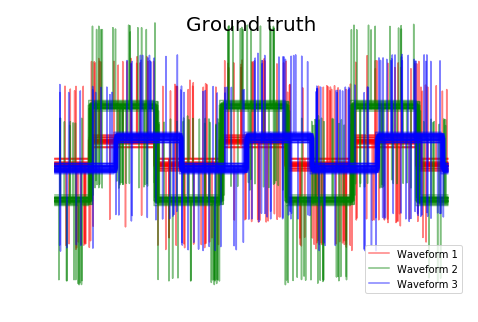

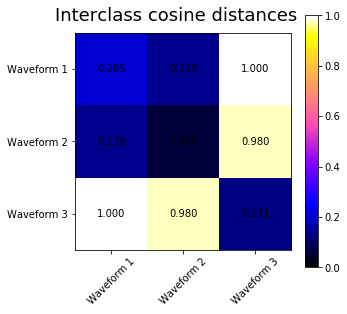

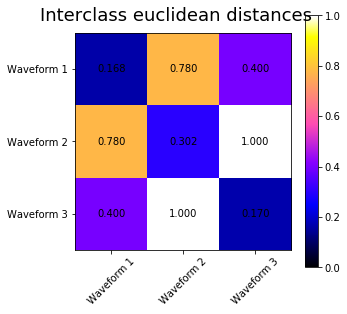

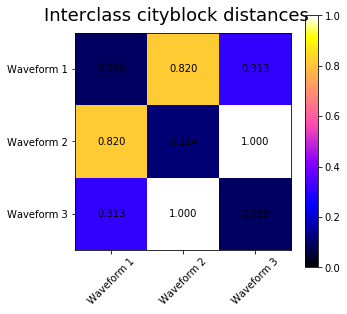

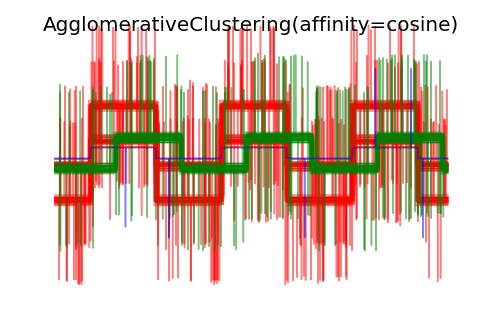

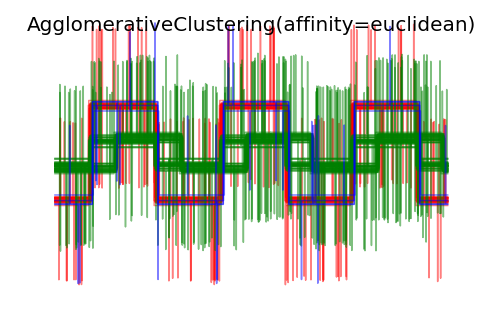

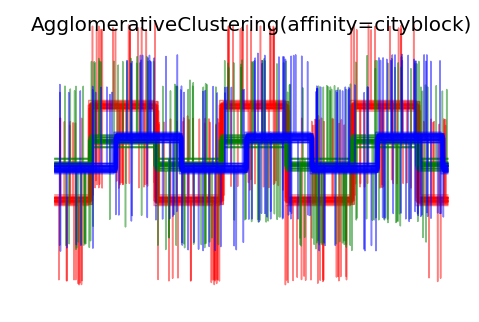

In [2]:
# Author: Gael Varoquaux
# License: BSD 3-Clause or CC-0

import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

np.random.seed(0)

# Generate waveform data
n_features = 2000
t = np.pi * np.linspace(0, 1, n_features)


def sqr(x):
    return np.sign(np.cos(x))

X = list()
y = list()
for i, (phi, a) in enumerate([(.5, .15), (.5, .6), (.3, .2)]):
    for _ in range(30):
        phase_noise = .01 * np.random.normal()
        amplitude_noise = .04 * np.random.normal()
        additional_noise = 1 - 2 * np.random.rand(n_features)
        # Make the noise sparse
        additional_noise[np.abs(additional_noise) < .997] = 0

        X.append(12 * ((a + amplitude_noise)
                 * (sqr(6 * (t + phi + phase_noise)))
                 + additional_noise))
        y.append(i)

X = np.array(X)
y = np.array(y)

n_clusters = 3

labels = ('Waveform 1', 'Waveform 2', 'Waveform 3')

# Plot the ground-truth labelling
plt.figure()
plt.axes([0, 0, 1, 1])
for l, c, n in zip(range(n_clusters), 'rgb',
                   labels):
    lines = plt.plot(X[y == l].T, c=c, alpha=.5)
    lines[0].set_label(n)

plt.legend(loc='best')

plt.axis('tight')
plt.axis('off')
plt.suptitle("Ground truth", size=20)


# Plot the distances
for index, metric in enumerate(["cosine", "euclidean", "cityblock"]):
    avg_dist = np.zeros((n_clusters, n_clusters))
    plt.figure(figsize=(5, 4.5))
    for i in range(n_clusters):
        for j in range(n_clusters):
            avg_dist[i, j] = pairwise_distances(X[y == i], X[y == j],
                                                metric=metric).mean()
    avg_dist /= avg_dist.max()
    for i in range(n_clusters):
        for j in range(n_clusters):
            plt.text(i, j, '%5.3f' % avg_dist[i, j],
                     verticalalignment='center',
                     horizontalalignment='center')

    plt.imshow(avg_dist, interpolation='nearest', cmap=plt.cm.gnuplot2,
               vmin=0)
    plt.xticks(range(n_clusters), labels, rotation=45)
    plt.yticks(range(n_clusters), labels)
    plt.colorbar()
    plt.suptitle("Interclass %s distances" % metric, size=18)
    plt.tight_layout()


# Plot clustering results
for index, metric in enumerate(["cosine", "euclidean", "cityblock"]):
    model = AgglomerativeClustering(n_clusters=n_clusters,
                                    linkage="average", affinity=metric)
    model.fit(X)
    plt.figure()
    plt.axes([0, 0, 1, 1])
    for l, c in zip(np.arange(model.n_clusters), 'rgbk'):
        plt.plot(X[model.labels_ == l].T, c=c, alpha=.5)
    plt.axis('tight')
    plt.axis('off')
    plt.suptitle("AgglomerativeClustering(affinity=%s)" % metric, size=20)


plt.show()

## DBSCAN

he DBSCAN algorithm views clusters as areas of high density separated by areas of low density. Due to this rather generic view, clusters found by DBSCAN can be any shape, as opposed to k-means which assumes that clusters are convex shaped. The central component to the DBSCAN is the concept of core samples, which are samples that are in areas of high density. A cluster is therefore a set of core samples, each close to each other (measured by some distance measure) and a set of non-core samples that are close to a core sample (but are not themselves core samples). There are two parameters to the algorithm, min_samples and eps, which define formally what we mean when we say dense. Higher min_samples or lower eps indicate higher density necessary to form a cluster.

Automatically created module for IPython interactive environment
Estimated number of clusters: 3
Homogeneity: 0.953
Completeness: 0.883
V-measure: 0.917
Adjusted Rand Index: 0.952
Adjusted Mutual Information: 0.883
Silhouette Coefficient: 0.626


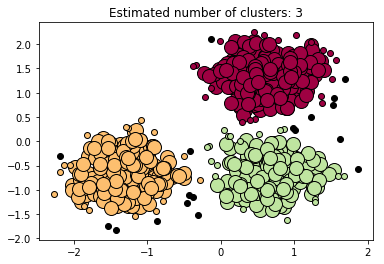

In [3]:
print(__doc__)

import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)

X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

The DBSCAN algorithm is deterministic, always generating the same clusters when given the same data in the same order. However, the results can differ when data is provided in a different order. First, even though the core samples will always be assigned to the same clusters, the labels of those clusters will depend on the order in which those samples are encountered in the data. Second and more importantly, the clusters to which non-core samples are assigned can differ depending on the data order. This would happen when a non-core sample has a distance lower than eps to two core samples in different clusters. By the triangular inequality, those two core samples must be more distant than eps from each other, or they would be in the same cluster. The non-core sample is assigned to whichever cluster is generated first in a pass through the data, and so the results will depend on the data ordering.

The current implementation uses ball trees and kd-trees to determine the neighborhood of points, which avoids calculating the full distance matrix. The possibility to use custom metrics is retained;

### Drawbacks


- Memory consumption for large sample sizes

    This implementation is by default not memory efficient because it constructs a full pairwise similarity matrix in the case where kd-trees or ball-trees cannot be used (e.g. with sparse matrices). This matrix will consume n^2 floats. A couple of mechanisms for getting around this are:

    - A sparse radius neighborhood graph (where missing entries are presumed to be out of eps) can be precomputed in a memory-efficient way and dbscan can be run over this with metric='precomputed'.
    - The dataset can be compressed, either by removing exact duplicates if these occur in your data, or by using BIRCH. Then you only have a relatively small number of representatives for a large number of points. You can then provide a sample_weight when fitting DBSCAN.

## Birch

The Birch builds a tree called the Characteristic Feature Tree (CFT) for the given data. The data is essentially lossy compressed to a set of Characteristic Feature nodes (CF Nodes). The CF Nodes have a number of subclusters called Characteristic Feature subclusters (CF Subclusters) and these CF Subclusters located in the non-terminal CF Nodes can have CF Nodes as children.

The CF Subclusters hold the necessary information for clustering which prevents the need to hold the entire input data in memory. This information includes:

- Number of samples in a subcluster.
- Linear Sum - A n-dimensional vector holding the sum of all samples
- Squared Sum - Sum of the squared L2 norm of all samples.
- Centroids - To avoid recalculation linear sum / n_samples.
- Squared norm of the centroids.

The Birch algorithm has two parameters, the threshold and the branching factor. The branching factor limits the number of subclusters in a node and the threshold limits the distance between the entering sample and the existing subclusters.

This algorithm can be viewed as an instance or data reduction method, since it reduces the input data to a set of subclusters which are obtained directly from the leaves of the CFT. This reduced data can be further processed by feeding it into a global clusterer. This global clusterer can be set by n_clusters. If n_clusters is set to None, the subclusters from the leaves are directly read off, otherwise a global clustering step labels these subclusters into global clusters (labels) and the samples are mapped to the global label of the nearest subcluster.

Algorithm description:

A new sample is inserted into the root of the CF Tree which is a CF Node. It is then merged with the subcluster of the root, that has the smallest radius after merging, constrained by the threshold and branching factor conditions. If the subcluster has any child node, then this is done repeatedly till it reaches a leaf. After finding the nearest subcluster in the leaf, the properties of this subcluster and the parent subclusters are recursively updated.
If the radius of the subcluster obtained by merging the new sample and the nearest subcluster is greater than the square of the threshold and if the number of subclusters is greater than the branching factor, then a space is temporarily allocated to this new sample. The two farthest subclusters are taken and the subclusters are divided into two groups on the basis of the distance between these subclusters.
If this split node has a parent subcluster and there is room for a new subcluster, then the parent is split into two. If there is no room, then this node is again split into two and the process is continued recursively, till it reaches the root.

Automatically created module for IPython interactive environment


/home/mayank/.local/lib64/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Compute structured hierarchical clustering...
Elapsed time:  0.7073819637298584
Number of pixels:  7752
Number of clusters:  15


/home/mayank/.local/lib64/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'contours'
  s)


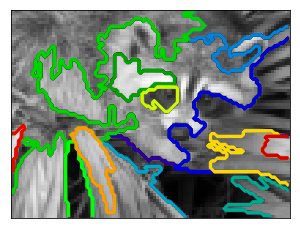

In [3]:
# Author : Vincent Michel, 2010
#          Alexandre Gramfort, 2011
# License: BSD 3 clause

print(__doc__)

import time as time

import numpy as np
import scipy as sp

import matplotlib.pyplot as plt

from sklearn.feature_extraction.image import grid_to_graph
from sklearn.cluster import AgglomerativeClustering


# #############################################################################
# Generate data
try:  # SciPy >= 0.16 have face in misc
    from scipy.misc import face
    face = face(gray=True)
except ImportError:
    face = sp.face(gray=True)

# Resize it to 10% of the original size to speed up the processing
face = sp.misc.imresize(face, 0.10) / 255.

X = np.reshape(face, (-1, 1))

# #############################################################################
# Define the structure A of the data. Pixels connected to their neighbors.
connectivity = grid_to_graph(*face.shape)

# #############################################################################
# Compute clustering
print("Compute structured hierarchical clustering...")
st = time.time()
n_clusters = 15  # number of regions
ward = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward',
                               connectivity=connectivity)
ward.fit(X)
label = np.reshape(ward.labels_, face.shape)
print("Elapsed time: ", time.time() - st)
print("Number of pixels: ", label.size)
print("Number of clusters: ", np.unique(label).size)

# #############################################################################
# Plot the results on an image
plt.figure(figsize=(5, 5))
plt.imshow(face, cmap=plt.cm.gray)
for l in range(n_clusters):
    plt.contour(label == l, contours=1,
                colors=[plt.cm.spectral(l / float(n_clusters)), ])
plt.xticks(())
plt.yticks(())
plt.show()

# Clustering performance evaluation

Evaluating the performance of a clustering algorithm is not as trivial as counting the number of errors or the precision and recall of a supervised classification algorithm. In particular any evaluation metric should not take the absolute values of the cluster labels into account but rather if this clustering define separations of the data similar to some ground truth set of classes or satisfying some assumption such that members belong to the same class are more similar that members of different classes according to some similarity metric.

## Adjusted Rand index

Given the knowledge of the ground truth class assignments labels_true and our clustering algorithm assignments of the same samples labels_pred, the adjusted Rand index is a function that measures the similarity of the two assignments, ignoring permutations and with chance normalization:

In [11]:
from sklearn import metrics
labels_true = [0, 0, 0, 1, 1, 1]
labels_pred = [0, 0, 1, 1, 2, 2]

metrics.adjusted_rand_score(labels_true, labels_pred)  

0.24242424242424246

One can permute 0 and 1 in the predicted labels, rename 2 to 3, and get the same score:



In [12]:
labels_pred = [1, 1, 0, 0, 3, 3]
metrics.adjusted_rand_score(labels_true, labels_pred)  

0.24242424242424246

Furthermore, adjusted_rand_score is symmetric: swapping the argument does not change the score. It can thus be used as a consensus measure:

In [13]:
metrics.adjusted_rand_score(labels_pred, labels_true)  

0.24242424242424246

Perfect labeling is scored 1.0:

In [14]:
labels_pred = labels_true[:]
metrics.adjusted_rand_score(labels_true, labels_pred)

1.0

Bad (e.g. independent labelings) have negative or close to 0.0 scores:



In [15]:
labels_true = [0, 1, 2, 0, 3, 4, 5, 1]
labels_pred = [1, 1, 0, 0, 2, 2, 2, 2]
metrics.adjusted_rand_score(labels_true, labels_pred)  

-0.12903225806451613

### Advantages

- Random (uniform) label assignments have a ARI score close to 0.0 for any value of n_clusters and n_samples (which is not the case for raw Rand index or the V-measure for instance).
- Bounded range [-1, 1]: negative values are bad (independent labelings), similar clusterings have a positive ARI, 1.0 is the perfect match score.
- No assumption is made on the cluster structure: can be used to compare clustering algorithms such as k-means which assumes isotropic blob shapes with results of spectral clustering algorithms which can find cluster with “folded” shapes.

### Drawbacks

Contrary to inertia, ARI requires knowledge of the ground truth classes while is almost never available in practice or requires manual assignment by human annotators (as in the supervised learning setting).

However ARI can also be useful in a purely unsupervised setting as a building block for a Consensus Index that can be used for clustering model selection (TODO).

Automatically created module for IPython interactive environment
Computing adjusted_rand_score for 10 values of n_clusters and n_samples=100
done in 0.043s
Computing v_measure_score for 10 values of n_clusters and n_samples=100
done in 0.060s
Computing adjusted_mutual_info_score for 10 values of n_clusters and n_samples=100
done in 0.665s
Computing mutual_info_score for 10 values of n_clusters and n_samples=100
done in 0.056s
Computing adjusted_rand_score for 10 values of n_clusters and n_samples=1000
done in 0.078s
Computing v_measure_score for 10 values of n_clusters and n_samples=1000
done in 0.088s
Computing adjusted_mutual_info_score for 10 values of n_clusters and n_samples=1000
done in 0.360s
Computing mutual_info_score for 10 values of n_clusters and n_samples=1000
done in 0.080s


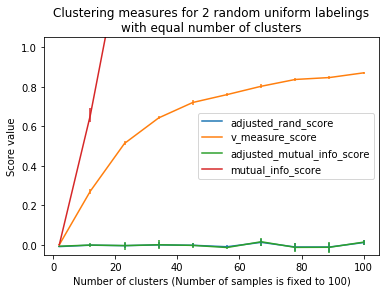

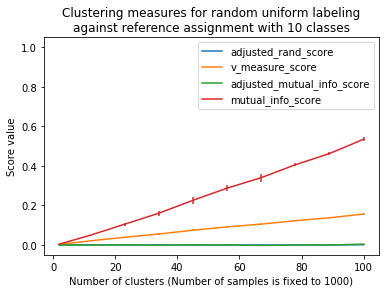

In [16]:
print(__doc__)

# Author: Olivier Grisel <olivier.grisel@ensta.org>
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn import metrics


def uniform_labelings_scores(score_func, n_samples, n_clusters_range,
                             fixed_n_classes=None, n_runs=5, seed=42):
    """Compute score for 2 random uniform cluster labelings.

    Both random labelings have the same number of clusters for each value
    possible value in ``n_clusters_range``.

    When fixed_n_classes is not None the first labeling is considered a ground
    truth class assignment with fixed number of classes.
    """
    random_labels = np.random.RandomState(seed).randint
    scores = np.zeros((len(n_clusters_range), n_runs))

    if fixed_n_classes is not None:
        labels_a = random_labels(low=0, high=fixed_n_classes, size=n_samples)

    for i, k in enumerate(n_clusters_range):
        for j in range(n_runs):
            if fixed_n_classes is None:
                labels_a = random_labels(low=0, high=k, size=n_samples)
            labels_b = random_labels(low=0, high=k, size=n_samples)
            scores[i, j] = score_func(labels_a, labels_b)
    return scores

score_funcs = [
    metrics.adjusted_rand_score,
    metrics.v_measure_score,
    metrics.adjusted_mutual_info_score,
    metrics.mutual_info_score,
]

# 2 independent random clusterings with equal cluster number

n_samples = 100
n_clusters_range = np.linspace(2, n_samples, 10).astype(np.int)

plt.figure(1)

plots = []
names = []
for score_func in score_funcs:
    print("Computing %s for %d values of n_clusters and n_samples=%d"
          % (score_func.__name__, len(n_clusters_range), n_samples))

    t0 = time()
    scores = uniform_labelings_scores(score_func, n_samples, n_clusters_range)
    print("done in %0.3fs" % (time() - t0))
    plots.append(plt.errorbar(
        n_clusters_range, np.median(scores, axis=1), scores.std(axis=1))[0])
    names.append(score_func.__name__)

plt.title("Clustering measures for 2 random uniform labelings\n"
          "with equal number of clusters")
plt.xlabel('Number of clusters (Number of samples is fixed to %d)' % n_samples)
plt.ylabel('Score value')
plt.legend(plots, names)
plt.ylim(ymin=-0.05, ymax=1.05)


# Random labeling with varying n_clusters against ground class labels
# with fixed number of clusters

n_samples = 1000
n_clusters_range = np.linspace(2, 100, 10).astype(np.int)
n_classes = 10

plt.figure(2)

plots = []
names = []
for score_func in score_funcs:
    print("Computing %s for %d values of n_clusters and n_samples=%d"
          % (score_func.__name__, len(n_clusters_range), n_samples))

    t0 = time()
    scores = uniform_labelings_scores(score_func, n_samples, n_clusters_range,
                                      fixed_n_classes=n_classes)
    print("done in %0.3fs" % (time() - t0))
    plots.append(plt.errorbar(
        n_clusters_range, scores.mean(axis=1), scores.std(axis=1))[0])
    names.append(score_func.__name__)

plt.title("Clustering measures for random uniform labeling\n"
          "against reference assignment with %d classes" % n_classes)
plt.xlabel('Number of clusters (Number of samples is fixed to %d)' % n_samples)
plt.ylabel('Score value')
plt.ylim(ymin=-0.05, ymax=1.05)
plt.legend(plots, names)
plt.show()

### Mutual Information based scores

Given the knowledge of the ground truth class assignments labels_true and our clustering algorithm assignments of the same samples labels_pred, the Mutual Information is a function that measures the agreement of the two assignments, ignoring permutations. Two different normalized versions of this measure are available, Normalized Mutual Information(NMI) and Adjusted Mutual Information(AMI). NMI is often used in the literature while AMI was proposed more recently and is normalized against chance:

In [17]:
from sklearn import metrics
labels_true = [0, 0, 0, 1, 1, 1]
labels_pred = [0, 0, 1, 1, 2, 2]

metrics.adjusted_mutual_info_score(labels_true, labels_pred) 

0.2250422831983088

One can permute 0 and 1 in the predicted labels, rename 2 to 3 and get the same score:

In [18]:
labels_pred = [1, 1, 0, 0, 3, 3]
metrics.adjusted_mutual_info_score(labels_true, labels_pred)  

0.2250422831983088

All, mutual_info_score, adjusted_mutual_info_score and normalized_mutual_info_score are symmetric: swapping the argument does not change the score. Thus they can be used as a consensus measure:

## Reference 
- http://scikit-learn.org/stable/auto_examples/cluster/plot_face_ward_segmentation.html
- https://pythonprogramming.net/hierarchical-clustering-machine-learning-python-scikit-learn/
- http://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering
- https://en.wikipedia.org/wiki/Rand_index#Adjusted_Rand_index
- http://link.springer.com/article/10.1007%2FBF01908075